## Imports

In [ ]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


## 0. Imports
### 0.1 Create pandas df for breast-cancer-detection 

In [ ]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

bcd_root_dir = Path('../raw_data/breast-cancer-detection')

data = []

for split in ['train', 'valid', 'test']:
    split_dir = bcd_root_dir / split
    for label in ['0', '1']:
        label_dir = split_dir / label
        for img_path in label_dir.glob('*.jpg'):
            data.append({
                'image_name': img_path.name,
                'image_path': str(img_path),
                'label': int(label),
                'split': split
            })

df = pd.DataFrame(data)

train_df = df[df['split'] == 'train']
val_df = df[df['split'] == 'valid']
test_df = df[df['split'] == 'test']

## 1. Preprocess data

In [ ]:
import sys

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [ ]:
preprocessor = Preprocessor()

In [ ]:
import numpy as np
import concurrent.futures

def preprocess_images_concurrently(df, preprocessor):
    """
    Preprocess images concurrently from a dataframe.

    Args:
        df: DataFrame containing 'image_path' and 'label' columns
        preprocessor: Object with preprocess_image method

    Returns:
        tuple: (X, y) where X is preprocessed images, y is labels
    """
    # Extract image paths and labels
    image_paths = df['image_path'].tolist()
    labels = df['label'].to_numpy()

    # Function to preprocess a single image
    def process_image(path):
        return preprocessor.preprocess_image(path)

    # Use ThreadPoolExecutor to preprocess images concurrently
    with concurrent.futures.ThreadPoolExecutor() as executor:
        X = list(executor.map(process_image, image_paths))

    # Convert list of numpy arrays to a single numpy array
    X = np.array(X)

    return X, labels


In [35]:
# For your train, validation, and test sets
X_train, y_train = preprocess_images_concurrently(train_df, preprocessor)
X_val, y_val = preprocess_images_concurrently(val_df, preprocessor)
X_test, y_test = preprocess_images_concurrently(test_df, preprocessor)


In [36]:
X_train.shape

(2372, 224, 224, 3)

In [38]:
# More explicit class weight calculation
from collections import Counter

# Count class distribution
class_counts = Counter(y_train.flatten())
total_samples = len(y_train)

# Calculate weights inversely proportional to frequency
class_weights_dict = {
    0: total_samples / (2 * class_counts[0]),
    1: total_samples / (2 * class_counts[1])
}

print("Class weights:", class_weights_dict)


Class weights: {0: 0.7558954748247291, 1: 1.4769613947696139}


In [46]:
import tensorflow as tf

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        focal_weight = alpha_t * tf.pow((1 - p_t), gamma)
        focal_loss = -focal_weight * tf.math.log(p_t)  # Changed tf.log to tf.math.log
        return tf.reduce_mean(focal_loss)
    return focal_loss_fixed

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Lambda
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.layers import Add

model = Sequential()

# Better initial feature extraction
model.add(Conv2D(32, (7, 7), strides=2, padding='same', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Less aggressive pooling, more feature maps
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# Global Average Pooling to reduce overfitting
model.add(GlobalAveragePooling2D())

# More sophisticated classifier
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))



model.compile(loss=focal_loss(gamma=2., alpha=0.75),
            optimizer=optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy', 'recall', 'precision'])
model.summary()

es = EarlyStopping(monitor='val_loss',
                   patience=5,
                   restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_loss',
                            factor=0.5,
                            patience=2,
                            min_lr=0.00001)

# Compute class weights
class_weights = compute_class_weight('balanced',
                                      classes=np.unique(y_train),
                                      y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

history = model.fit(X_train, y_train,
                    epochs=30,
                    class_weight=class_weights_dict,
                    batch_size=64,
                    callbacks=[es, plateau],
                    validation_data=(X_val, y_val),
                    verbose=1)

predictions = model.evaluate(X_test, y_test, verbose=1)
print(f"Test metrics: {predictions}")

/Users/mattisweber/.pyenv/versions/3.10.6/envs/lewagon-breast-cancer-project/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_114 (Conv2D)             │ (None, 112, 112, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_61 (Activation)      │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_62 (Activation)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_63 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_64 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_65 (Activation)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_66 (Activation)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             

 Total params: 1,330,753 (5.08 MB)

 Trainable params: 1,329,025 (5.07 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.4643 - loss: 0.3853 - precision: 0.3367 - recall: 0.5924 - val_accuracy: 0.6637 - val_loss: 0.1740 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.4721 - loss: 0.2068 - precision: 0.3289 - recall: 0.5900 - val_accuracy: 0.3363 - val_loss: 0.0963 - val_precision: 0.3363 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.4516 - loss: 0.2470 - precision: 0.3454 - recall: 0.7273 - val_accuracy: 0.3526 - val_loss: 0.0731 - val_precision: 0.3399 - val_recall: 0.9824 - learning_rate: 0.0010
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4977 - loss: 0.2356 - precision: 0.3792 - recall: 0.6049 - val_accuracy: 0.3822 - val_loss: 0.0781 - val_precision: 0.3497 - val_recall: 0.9736 - learning_rate: 0.0010
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.

In [54]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step


In [55]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[  5 203]
 [  0 128]]


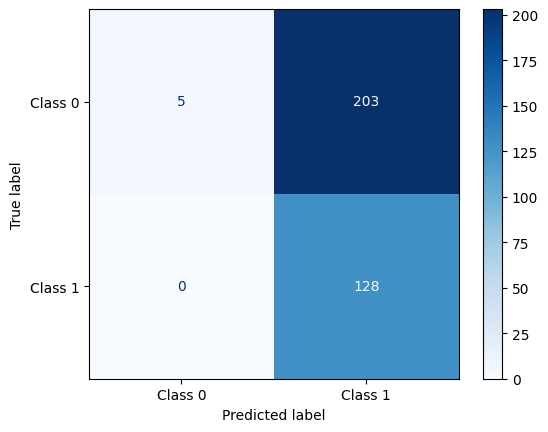

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [43]:
# Try different thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
for threshold in thresholds:
    y_pred = (model.predict(X_test) > threshold).astype(int).flatten()
    cm = confusion_matrix(y_test, y_pred)
    print(f"Threshold {threshold}:")
    print(cm)
    print()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Threshold 0.1:
[[  0 208]
 [  0 128]]

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Threshold 0.2:
[[  0 208]
 [  0 128]]

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Threshold 0.3:
[[  0 208]
 [  0 128]]

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Threshold 0.4:
[[145  63]
 [ 83  45]]

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Threshold 0.5:
[[208   0]
 [128   0]]



### 2. Try #2

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_model(input_shape=(224, 224, 3)):
    # Base model with pre-trained weights
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )

    # Custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Combined model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile with competition-specific parameters
    model.compile(
        optimizer=Adam(learning_rate=3e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC']
    )

    return model

def train_model(model, X_train, y_train, X_val, y_val):
    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Competition-specific callbacks
    callbacks = [
        ModelCheckpoint(
            'best_model.h5',
            save_best_only=True,
            monitor='val_AUC',
            mode='max'
        ),
        ReduceLROnPlateau(
            monitor='val_AUC',
            factor=0.5,
            patience=3,
            verbose=1,
            mode='max'
        ),
        EarlyStopping(
            monitor='val_AUC',
            patience=10,
            verbose=1,
            mode='max'
        )
    ]

    # Training with 4-fold validation strategy
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),
        steps_per_epoch=len(X_train) // 32,
        validation_data=(X_val, y_val),
        epochs=50,
        callbacks=callbacks,
        class_weight={0:1, 1:5}  # Handling class imbalance
    )

    return model, history


In [ ]:
# Example usage
model = create_model()
trained_model, history = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val
)


/Users/mattisweber/.pyenv/versions/3.10.6/envs/lewagon-breast-cancer-project/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 3:03:37 151s/step - AUC: 0.6333 - accuracy: 0.6250 - loss: 1.7047

/Users/mattisweber/.pyenv/versions/3.10.6/envs/lewagon-breast-cancer-project/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


74/74 ━━━━━━━━━━━━━━━━━━━━ 375s 3s/step - AUC: 0.6607 - accuracy: 0.5788 - loss: 1.4950 - val_AUC: 0.5099 - val_accuracy: 0.6637 - val_loss: 0.6322 - learning_rate: 3.0000e-04
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - AUC: 0.5329 - accuracy: 0.4081 - loss: 1.5241

74/74 ━━━━━━━━━━━━━━━━━━━━ 768s 9s/step - AUC: 0.5332 - accuracy: 0.4082 - loss: 1.5238 - val_AUC: 0.5246 - val_accuracy: 0.3363 - val_loss: 0.7437 - learning_rate: 3.0000e-04
Epoch 3/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 11:57 10s/step - AUC: 0.6964 - accuracy: 0.5625 - loss: 1.2251

/Users/mattisweber/.pyenv/versions/3.10.6/envs/lewagon-breast-cancer-project/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - AUC: 0.6964 - accuracy: 0.5625 - loss: 1.2251 - val_AUC: 0.5384 - val_accuracy: 0.3363 - val_loss: 0.7453 - learning_rate: 3.0000e-04
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 427s 6s/step - AUC: 0.6002 - accuracy: 0.4353 - loss: 1.4308 - val_AUC: 0.5069 - val_accuracy: 0.6563 - val_loss: 0.6830 - learning_rate: 3.0000e-04
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 106ms/step - AUC: 0.3225 - accuracy: 0.4062 - loss: 1.7542 - val_AUC: 0.5024 - val_accuracy: 0.6533 - val_loss: 0.6837 - learning_rate: 3.0000e-04
Epoch 6/50
33/74 ━━━━━━━━━━━━━━━━━━━━ 4:18 6s/step - AUC: 0.5617 - accuracy: 0.3865 - loss: 1.4345
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
74/74 ━━━━━━━━━━━━━━━━━━━━ 240s 3s/step - AUC: 0.5600 - accuracy: 0.3908 - loss: 1.4451 - val_AUC: 0.4660 - val_accuracy: 0.4444 - val_loss: 0.7013 - learning_rate: 3.0000e-04
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 473s 6s/step - AUC: 0.5723 - accuracy: 0.4036 - loss: 1.4

11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 872ms/step
[[ 20 188]
 [ 12 116]]


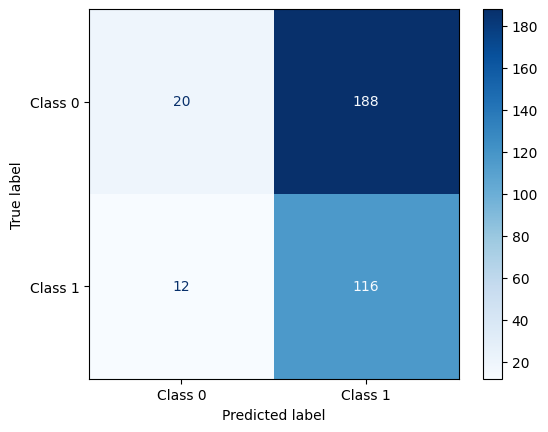

In [63]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.show()